# ``VAE2d`` Demo

To use this demo, create the conda env defined in ``requirements-dev.conda.yaml``. To demonstrate ``torch_tools.VAE2d``, we use it to encode and decode MNIST images.

In [1]:
from pathlib import Path

from pandas import DataFrame

from torch_tools.file_utils import traverse_directory_tree


parent_dir = Path("/home/jim/storage/ovarian-histology/")

metadata = DataFrame(
    columns=["patch_path"],
    data=traverse_directory_tree(parent_dir),
)

metadata["patch_name"] = metadata.patch_path.apply(lambda x: x.name)
metadata["slide"] = metadata.patch_path.apply(lambda x: x.parent.name)

metadata = metadata.sort_values(by=["slide", "patch_name"])


valid_slides = metadata.slide.drop_duplicates().sample(n=3, random_state=123).to_list()

train_data = metadata.loc[~metadata.slide.isin(valid_slides)]
valid_data = metadata.loc[metadata.slide.isin(valid_slides)]



print(f"There are {len(train_data)} training patches")
print(f"There are {len(valid_data)} validation patches")

There are 6000 training patches
There are 3000 validation patches


In [2]:
from torch_tools import DataSet

from skimage.io import imread

from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, RandomCrop, ColorJitter


def input_tfms(training: bool) -> Compose:
    """Return a composition of input transforms.

    Parameters
    ----------
    training : bool
        Are we training, or validating?

    """
    tfm_list = [imread, ToTensor(), RandomCrop(256)]

    if training is True:
        tfm_list.append(
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        )

    return Compose(tfm_list)


train_set = DataSet(
    train_data.patch_path.to_list(),
    input_tfms=input_tfms(True),
)

valid_set = DataSet(
    valid_data.patch_path.to_list(),
    input_tfms=input_tfms(False),
)


print(train_set[0].shape)
print(valid_set[0].shape)

bs = 8

train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=bs, shuffle=True)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In this demo, we want bother with a validation loop during training, and will just use the validation set to do some inference at the end. Let's instantiate the model.

In [3]:
from torch.cuda import is_available
from torch import manual_seed

from torch_tools import VAE2d

manual_seed(123)


DEVICE = "cuda" if is_available() else "cpu"

model = VAE2d(
    in_chans=3,
    out_chans=3,
    # input_dims=(256, 256),
    num_layers=4,
    start_features=32,
    block_style="conv_res",
    mean_var_nets="conv"
).to(DEVICE)

print(f"Device set to {DEVICE}")

print(model)

Device set to cuda
VAE2d(
  (encoder): Encoder2d(
    (0): ConvResBlock(
      (0): ConvBlock(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ResidualBlock(
        (first_conv): ConvBlock(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.0)
        )
        (second_conv): ConvBlock(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      

Now, we set up the optimiser and loss function.

In [4]:
from torch.optim import Adam
from torch.nn import L1Loss

optimiser = Adam(model.parameters(), lr=1e-4)

loss_func = L1Loss()

And now we write our training loop.

In [5]:
from torch.nn import Module


def train_one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Adam,
    loss_func: L1Loss,
) -> float:
    """Train ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    optimiser : Adam
        Adam optimiser.
    loss_func : L1Loss
        The L1 loss function.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    model.train()
    metrics = {"l1_loss": 0.0, "kl_loss": 0.0}
    for batch in data_loader:
        optimiser.zero_grad()

        batch = batch.to(DEVICE)

        preds, kl_div = model(batch)

        l1_loss = loss_func(preds.tanh(), batch)

        (l1_loss + kl_div).backward()

        optimiser.step()

        metrics["l1_loss"] += l1_loss.item()
        metrics["kl_loss"] += kl_div.item()

    return {key: val / len(data_loader) for key, val in metrics.items()}


def validate_one_epoch(
    model: Module,
    data_loader: DataLoader,
    loss_func: L1Loss,
) -> float:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    loss_func : L1Loss
        The L1 loss function.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    model.eval()
    metrics = {"l1_loss": 0.0}
    for batch in data_loader:
        optimiser.zero_grad()

        batch = batch.to(DEVICE)

        preds = model(batch)

        l1_loss = loss_func(preds.tanh(), batch)

        l1_loss.backward()

        optimiser.step()

        metrics["l1_loss"] += l1_loss.item()

    return {key: val / len(data_loader) for key, val in metrics.items()}

Now we can train the model.

In [6]:
from time import perf_counter, sleep

from numpy import floor

epochs = 25

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start = perf_counter()

    train_metrics.append(
        train_one_epoch(
            model,
            train_loader,
            optimiser,
            loss_func,
        )
    )

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func))

    stop = perf_counter()

    mins = int(floor((stop - start) / 60.0))
    secs = (stop - start) % 60.0

    print(f"{epoch + 1} Epoch time : {mins} mins and {secs:.3f} secs")

    sleep(180)

1 Epoch time : 5 mins and 23.197 secs
2 Epoch time : 5 mins and 22.086 secs
3 Epoch time : 5 mins and 22.718 secs
4 Epoch time : 5 mins and 22.912 secs
5 Epoch time : 5 mins and 22.281 secs
6 Epoch time : 5 mins and 20.659 secs
7 Epoch time : 5 mins and 22.485 secs
8 Epoch time : 5 mins and 21.084 secs
9 Epoch time : 5 mins and 22.399 secs
10 Epoch time : 5 mins and 23.873 secs
11 Epoch time : 5 mins and 21.917 secs
12 Epoch time : 5 mins and 21.948 secs
13 Epoch time : 5 mins and 23.940 secs
14 Epoch time : 5 mins and 22.428 secs
15 Epoch time : 5 mins and 22.709 secs
16 Epoch time : 5 mins and 20.050 secs
17 Epoch time : 5 mins and 22.166 secs
18 Epoch time : 5 mins and 23.002 secs
19 Epoch time : 5 mins and 20.989 secs
20 Epoch time : 5 mins and 22.580 secs
21 Epoch time : 5 mins and 23.373 secs
22 Epoch time : 5 mins and 22.521 secs
23 Epoch time : 5 mins and 23.160 secs
24 Epoch time : 5 mins and 23.614 secs
25 Epoch time : 5 mins and 23.209 secs


    l1_loss_train   kl_loss  l1_loss_valid
0        0.222022  0.007485       0.072688
1        0.095292  0.009936       0.055523
2        0.082497  0.010267       0.052722
3        0.078271  0.010446       0.050592
4        0.074502  0.010987       0.049574
5        0.073833  0.011112       0.048338
6        0.074911  0.011737       0.047259
7        0.071665  0.011639       0.046790
8        0.071175  0.011749       0.045648
9        0.070067  0.012013       0.044831
10       0.068864  0.012412       0.044732
11       0.066502  0.012949       0.044661
12       0.065702  0.013171       0.043775
13       0.064746  0.013245       0.043301
14       0.064491  0.013269       0.042940
15       0.064424  0.013355       0.042277
16       0.063854  0.013396       0.042596
17       0.063042  0.013436       0.042307
18       0.062669  0.013486       0.042253
19       0.062546  0.013501       0.041872
20       0.061894  0.013547       0.041955
21       0.061918  0.013537       0.041461
22       0.

Text(0, 0.5, 'Loss')

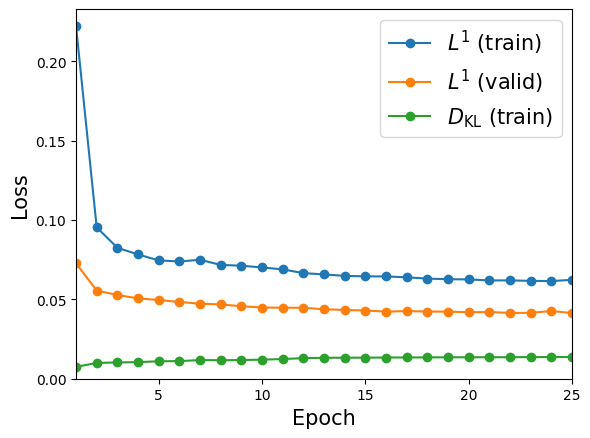

In [7]:
import matplotlib.pyplot as plt
from pandas import DataFrame

from numpy import linspace


metrics = DataFrame(train_metrics).join(
    DataFrame(valid_metrics),
    lsuffix="_train",
    rsuffix="_valid",
)

x_vals = linspace(1, len(metrics), len(metrics))

print(metrics)

figure, axes = plt.subplots(1, 1)
axes.plot(x_vals, metrics["l1_loss_train"], "-o", label=r"$L^{1}$ (train)")
axes.plot(x_vals, metrics["l1_loss_valid"], "-o", label="$L^{1}$ (valid)")
axes.plot(x_vals, metrics["kl_loss"], "-o", label=r"$D_{\mathrm{KL}}$ (train)")


axes.set_ylim(bottom=0.0)
axes.set_xlim(left=1.0, right=len(metrics) if len(metrics) != 1 else None)

axes.legend(fontsize=15)

axes.set_xlabel("Epoch", fontsize=15)
axes.set_ylabel("Loss", fontsize=15)

In [8]:
for batch in valid_loader:
    break


Now we can take a look at some predictions from the validation loader.


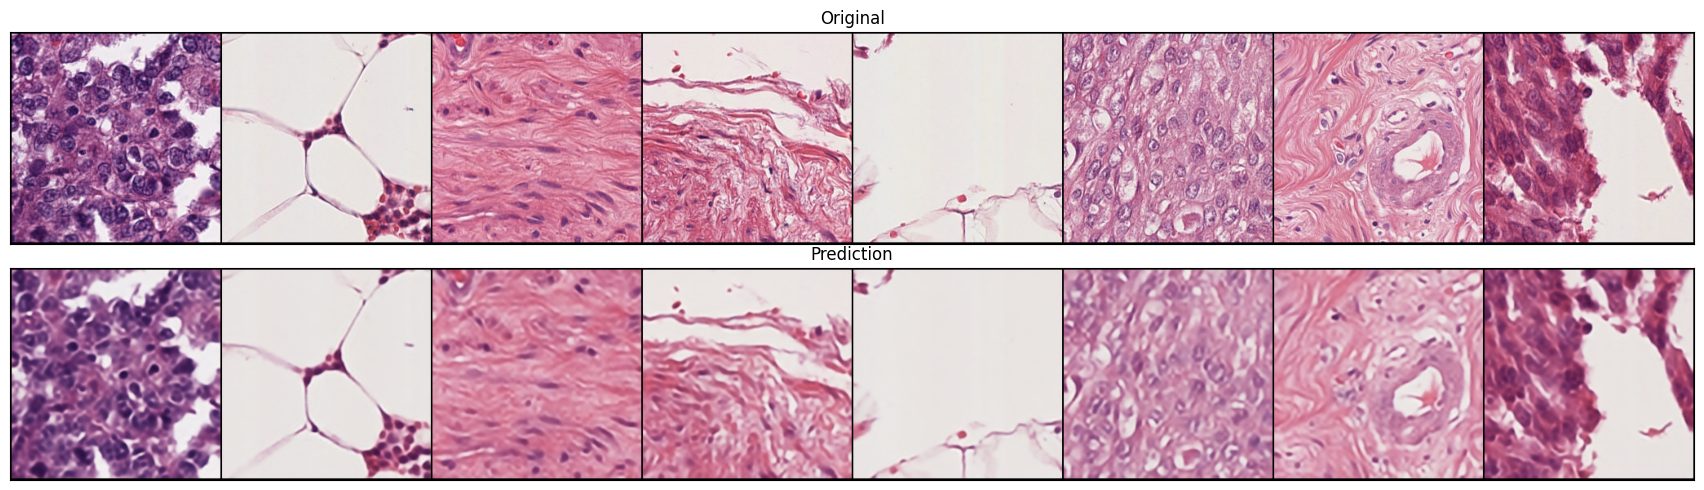

In [9]:
plt.close("all")

from torch import no_grad
from torchvision.utils import make_grid

with no_grad():
    model.eval()
    preds = model(batch.to(DEVICE)).tanh().detach()


batch_grid = make_grid(batch.cpu(), nrow=10).permute(1, 2, 0)
pred_grid = make_grid(preds.detach().cpu(), nrow=10).permute(1, 2, 0)


pred_grid = pred_grid.clip(0.0, 1.0)


size = 2.5
figure, axes = plt.subplots(2, 1, figsize=(len(batch) * size, 2 * size))
axes[0].imshow(batch_grid)
axes[1].imshow(pred_grid)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_title("Original")
axes[1].set_title("Prediction")

figure.tight_layout(h_pad=0.1)